# Data Extraction and Detecting Time Series Components

First thing first, let me import the Python libraries first.

In [1]:
import requests
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

For the sake of practice, let me work with telecom industry and to do that I pick `AT&T` (T) and `Verizon` (VZ). As a stock price I choose closing price, which is more stable and informative compared to high, low, open. Adjusted closing price would be an another good choice. 

The period that I cover is 01/01/2020-06/01/2021 and the stock price data is daily, meaning that we have 253 observations. 

Please note that you can also use [pandas datareader](https://pandas-datareader.readthedocs.io/en/latest/) to make use of yahoo finance as well as other APIs to access the stock price

In [2]:
def getDailyData(symbol):
        parameters = {'function': 'TIME_SERIES_DAILY_ADJUSTED', 'symbol': symbol,
                       'outputsize':'full',
                       'datatype': 'csv', 
                       'apikey': 'LL1WA15IW41XV2T2'}

        response = requests.get('https://www.alphavantage.co/query', params=parameters)

        # Process the CSV file retrieved
        csvText = StringIO(response.text)
        data = pd.read_csv(csvText, index_col='timestamp')
        return data

In [3]:
symbols= ['T', 'VZ']
data=[]
for symbol in symbols:
    data.append(getDailyData(symbol)[::-1]['close']['2019,1,1': '2021,6,1'])# <4>
stock_prices=pd.DataFrame(data).T
stock_prices.columns=symbols

In [4]:
stock_prices.to_csv('stock_prices.csv')

In [5]:
stock_prices['timestamp'] = pd.to_datetime(stock_prices.index)
stock_prices.set_index(stock_prices['timestamp'])
del stock_prices['timestamp']

In [6]:
stock_prices.head()

,T,VZ
timestamp,,
2019-01-02,29.54,56.02
2019-01-03,29.58,56.22
2019-01-04,30.34,56.36
2019-01-07,30.89,56.72
2019-01-08,31.28,58.38


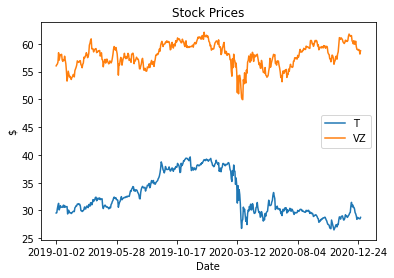

In [7]:
stock_prices.plot()
plt.title('Stock Prices')
plt.ylabel('$')
plt.xlabel('Date')
plt.show()

There are some striking observation that I can get from this plot. One of them is the sudden drop occured in the mid of 2020. This corresponds to Covid-19 pandemic and therefore it makes sense to say that pandemic badly affected the stock prices in telecom industry as well as others. The other important observation is that stock price of Verizon exhibits a clear upward movement. However, even though a modest upward trend is visible during pre-Covid-19 era for AT&T, the stock price of this company has not revert back to its previous level.

Before modeling time series, it is required to check the stationarity of the data. To do that, I need to decompose time series components. Because, in the presence of trend and seasonality (two main time series components), we can say that data is not stationary.

The basic assumption in modeling is that  $𝑋_𝑖$ should be independent from other realizations. If independence assumption does not hold, the result of the model cannot be reliable any more. Stationary is a way to model the dependent structure that we have in time-dependent data. For instance, current stock price is somewhat related to the previous prices of the stock.

One of the most important thing that I need to do is to detecting time series components. In time series, there are four components, which are:

* Trend
* Seasonality
* Cyclicality
* Residual

Those who wants to learn more, you can refer to `Exploring Data Science` and here is a quote from Chapter 15.2.2 from the book:

"Time-series data that have a seasonal aspect (such as monthly or quarterly data) can be decomposed into a trend component, a seasonal component, and an irregular component. The trend component captures changes in level over time. The seasonal component captures cyclical effects due to the time of year. The irregular (or error) component captures those influences not described by the trend and seasonal effects."

`seasonal_decompose` is a very convenient and helpful tool in identifying the components in Python.

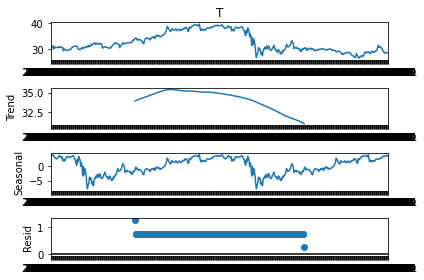

In [8]:
seasonal_decompose(stock_prices['T'], 
                   model = 'additive', 
                   period = int(len(stock_prices)/2)).plot();

Well, now we have three components of the time series. The first plot represents the behavior of raw data and the rest three plots exhibits the trend, seasonality, and residuals.

Let me briefly discuss the additive model with a period of 360. In time series, multiplicative model works well if the amplitude of both the seasonal and irregular variations increase as the level of the trend rises. Alternatively, additive model is suitable when the amplitude of both the seasonal and irregular variations do not change as the level of the trend rises or falls.

In `seasonal_decompose` library, we need to identify the period as long as we do not have timeseries index. Given the period of the data, the parameter period changes. For instance, if the data period is daily, then period becomes 360 and if the data period is monthly, the period takes the value of 12.

First, I decompose the time series analysis and it turns out trend is not clear for AT&T and similar story holds for Verizon, too.

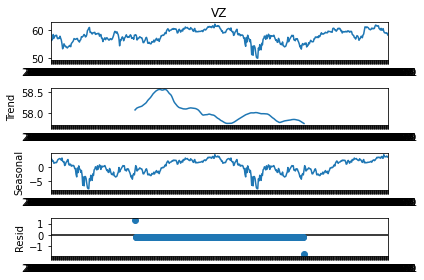

In [9]:
seasonal_decompose(stock_prices['VZ'], 
                   model='additive', 
                   period = int(len(stock_prices)/2)).plot();

On the contrary, the trend in Verizon is obvious and upward. As for the seasonality, it is hard to tell with same certainty. There is ups and downs but it is not periodic, which is an essential feature to have seasonality.

Another strong tools in detecting trend and seasonality are autocorrelation function and partial autocorrelation function. Let's start off with autocorrelation function.

Autocorrelation function, known as `ACF`, is a statistical tool to analyze the relationship between current value of a time series and its lagged values. Graphing ACF enables us to readily observe the serial dependence in a time series.

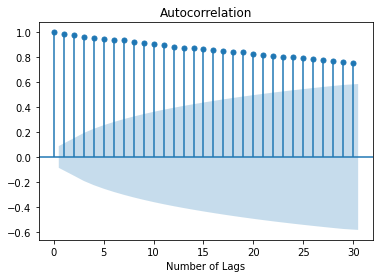

In [10]:
sm.graphics.tsa.plot_acf(stock_prices['T'],lags=30)
plt.xlabel('Number of Lags')
plt.show()

ACF confirms that there is a trend in AT&T in that the correlations decay very slowly. In a data with no trend, immediate decaying in correlation is something that we observe. Likewise, acf shows no presence of seasonality as no periodic ups and downs are observed.

The blue line in the acf plot denotes the confidence interval. If the correlation coefficient lies above or below it, it means that null hypothesis, denoting the presence of autocorrelation, is rejected. Alternatively, if the correlation coefficient lies within the confidence band, it amounts to no autocorrelation.

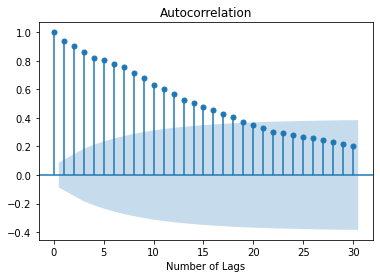

In [11]:
sm.graphics.tsa.plot_acf(stock_prices['VZ'],lags=30)
plt.xlabel('Number of Lags')
plt.show()

In the same vein, acf plot drawn for Verizon shows a strong sign of trend. In addition to that, it appears that seasonality does not exist, too.

Please refer to this website for more information about acf [acf-penn state](https://online.stat.psu.edu/stat462/node/188)

All right, let's continue with pacf, which is partial autocorrelation function. In Machine Learning in Finance (p.197-198) says that:

"Autoregressive models carry a signature which allows its order, p, to be determoned from time series data provided the data is stationary. This signature encodes the memory in the model and is given by partial autocorrelations."

PACF provides information on correlation between current value of a time series and its lagged values controlling for the other correlations. Mathematically,

$$
\hat \rho(h)= \frac{\text{Cov}(X_t,X_{t-h}|X_{t-1},X_{t-2}\ldots X_{t-h-1})}{\sqrt{\text{Var}(X_t|X_{t-1},X_{t-2},\ldots, X_{t-h-1})\text{Var}(X_{t-h}|X_{t-1},X_{t-2},\ldots, X_{t-h-1})}}
$$

where X denotes time series.

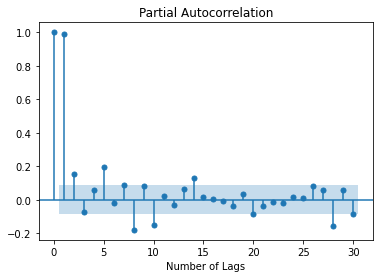

In [12]:
sm.graphics.tsa.plot_pacf(stock_prices['T'],lags=30)
plt.xlabel('Number of Lags')
plt.savefig('pacf_T.png')
plt.show()

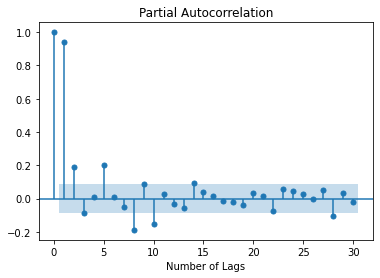

In [13]:
sm.graphics.tsa.plot_pacf(stock_prices['VZ'],lags=30)
plt.xlabel('Number of Lags')
plt.savefig('pacf_VZ.png')
plt.show()

PACF plot basically exhibits that many observations are within the confidence interval. Other than that, there are some spikes but it does not imply seasonality both for Verizon and AT&T.

Please refer to this website for more information about pacf [pacf-penn state](https://online.stat.psu.edu/stat510/lesson/2/2.2).

So, the upshot is before moving into the time series modeling, first we need to explore data using basic plotting along with seasonal decomposition, ACF, and PACF. All these are done to detect seasonality and trend and it turns out both of the stock prices appears to have trend but not seasonality.

## Dealing with Stationarity via Statistical Tool and Visualization

Let me apply statistical tool to confirm that both data have trend component. Augmented Dickey Fuller (adf) is most commonly used test to check the stationary.

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
stat_test=adfuller(stock_prices['T'])[0:2]
print(f'The test statistic and p-value for AT&T are {stat_test}')

The test statistic and p-value for AT&T are (-1.1856243786134169, 0.6797489695872558)


In [16]:
stat_test=adfuller(stock_prices['VZ'])[0:2]
print(f'The test statistic and p-value for VZ are {stat_test}')

The test statistic and p-value for VZ are (-3.114513580391114, 0.02549759690348691)


Well, looking at p-value, which are 0.6797 for AT&T and 0.0254 for Verizon, it can be readily concluded that the data is not stationary as we accept the null hypothesis stating that there is a unit root.

All right, let's deal with this simply by taking the difference. Taking difference makes, most of the time, the data stationary.

In [17]:
diff_VZ = stock_prices['VZ'].diff().dropna()
diff_T = stock_prices['T'].diff().dropna()

In [18]:
stat_test=adfuller(diff_T)[0:2]
print(f'The test statistic and p-value for AT&T are {stat_test}')

The test statistic and p-value for AT&T are (-6.629083586827914, 5.775849021851074e-09)


In [19]:
stat_test=adfuller(diff_VZ)[0:2]
print(f'The test statistic and p-value for VZ are {stat_test}')

The test statistic and p-value for VZ are (-6.520162155970795, 1.0470237769206731e-08)


And, it did! Now, now we have stationary data and now let me visualize and see what it looks like. I will utilize line plot as well as ACF.

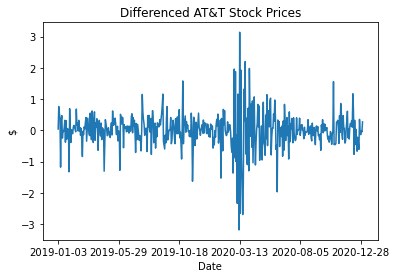

In [20]:
diff_T.plot()
plt.title('Differenced AT&T Stock Prices')
plt.ylabel('$')
plt.xlabel('Date')
plt.show()

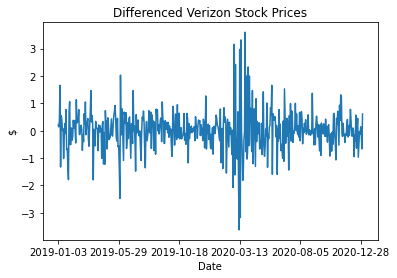

In [21]:
diff_VZ.plot()
plt.title('Differenced Verizon Stock Prices')
plt.ylabel('$')
plt.xlabel('Date')
plt.show()

Both the differenced stock prices of AT&T and Verizon seems to fluctuate around zero, which is something that I expect when data becomes stationary.

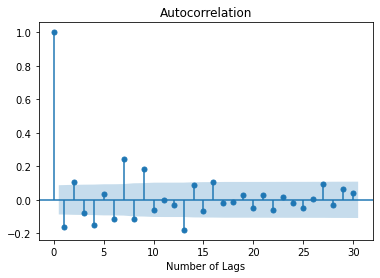

In [22]:
sm.graphics.tsa.plot_acf(diff_T,lags=30)
plt.xlabel('Number of Lags')
plt.show()

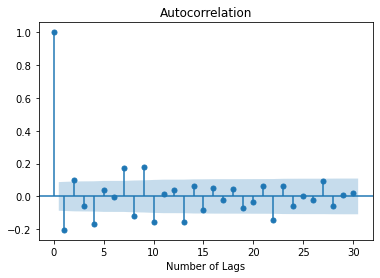

In [23]:
sm.graphics.tsa.plot_acf(diff_VZ,lags=30)
plt.xlabel('Number of Lags')
plt.show()

Likewise, ACF plot exhibits a very fast decay and stays within the confidence interval band aside from some observations. These observations can be used for identifying the optimal number of lag in modeling. This is the topic of the next milestone.

Well, as `diff_T` and `diff_VZ` are stationary, these two data will be utilized during time series modeling.